# Q1 
## part a
After Google searching all the minibus which can arrive at HKUST, the route code is:
Northern Entrance: 11/11M, 12, Southern Entrance: 11, 104 

In [99]:
import requests
import pandas as pd

url = "https://data.etagmb.gov.hk"
route_code_list = ["11", "11M", "11B", "11S", "12", "104"]
route_code_route_id_dict = {}

for route_code in route_code_list:
    endpoint_get_route_id = url + "/route/NT/" + route_code

    response = requests.get(endpoint_get_route_id)

    if response.status_code == 200:
        response_data = response.json()['data']
        print(f"route {route_code} has route id:")
        for data in response_data:
            route_code_route_id_dict[route_code] = data['route_id']
            print(data['route_id'])
        print("==================================")
    else:
        print("Failed to retrieve data")

route 11 has route id:
2004791
route 11M has route id:
2004825
route 11B has route id:
2004827
2004828
route 11S has route id:
2004826
route 12 has route id:
2004763
2004764
route 104 has route id:
2007200


# part b

In [100]:
HKUST = "Hong Kong University of Science and Technology"
sequence_list = ['1', '2', '3']
route_stop_info = {}
for route_code in route_code_route_id_dict.keys():
    route_id = route_code_route_id_dict[route_code]
    route_stop_info[route_id] = []
    for sequence_id in sequence_list:
        response = requests.get(url + "/route-stop/" + str(route_id) + "/" + sequence_id)

        if response.status_code != 200:
            continue
            
        response_data = response.json()['data']
        stops_data = response_data['route_stops']
        find_hkust = False
        for stop in stops_data:
            if HKUST not in stop['name_en']:
                continue
            stop_info = {}
            stop_info['stop_id'] = stop['stop_id']
            stop_info['stop_name_en'] = stop['name_en']
            stop_info['sequence_id'] = sequence_id
            find_stop_info = False
            for st in route_stop_info[route_id]:
                if stop_info['stop_id'] == st['stop_id']:
                    find_stop_info = True
                    break
            if not find_stop_info:
                route_stop_info[route_id].append(stop_info)

for route_code in route_code_route_id_dict.keys():
    route_id = route_code_route_id_dict[route_code]
    for stop_info in route_stop_info[route_id]:
        print(f"route: {route_code} ; stop: {stop_info['stop_name_en']} ;")

route: 11 ; stop: Hong Kong University of Science and Technology (South Station) ;
route: 11 ; stop: Hong Kong University of Science and Technology (North Station) ;
route: 11M ; stop: Hong Kong University of Science and Technology (North Station) ;
route: 11B ; stop: Hong Kong University of Science and Technology (South Station) ;
route: 11S ; stop: Hong Kong University of Science and Technology (South Station) ;
route: 11S ; stop: Hong Kong University of Science and Technology (North Station) ;
route: 12 ; stop: Hong Kong University of Science and Technology ;
route: 104 ; stop: Hong Kong University of Science and Technology (South Station) ;


According to the output, we can find that there is 8 routes which can arrive at HKUST. And after searching in the google, route code 12's stop of HKUST is HKUST north gate.
## part c

In [101]:
from datetime import datetime, timezone, timedelta

minibus_to_north_gate = []
minibus_to_south_gate = []

for route_id in route_stop_info.keys():
    for stop_info in route_stop_info[route_id]:
        if stop_info['stop_name_en'] == "Hong Kong University of Science and Technology (South Station)":
            minibus_to_south_gate.append(route_id)
        else:
            minibus_to_north_gate.append(route_id)


def get_diff_time(eta_time):
    given_datetime = datetime.fromisoformat(eta_time)
    # 获取当前时间
    current_datetime = datetime.now(timezone.utc).astimezone(given_datetime.tzinfo)

    # 计算时间差
    time_difference = given_datetime - current_datetime

    # 将时间差转换为小时和分钟
    hours, remainder = divmod(time_difference.total_seconds(), 3600)
    minutes, _ = divmod(remainder, 60)

    # 格式化为"hh:mm"
    return f"{int(hours):02}:{int(minutes):02}"

def get_timetable(direction):
    ets_result = []
    if direction == "N":
        minibus_list = minibus_to_north_gate
    elif direction == "S":
        minibus_list = minibus_to_south_gate
    else:
        return pd.DataFrame()
    
    for route_id in minibus_list:
        stop_info_list = route_stop_info[route_id]
        for stop_info in stop_info_list:
            if direction == "N" and stop_info['stop_name_en'] == "Hong Kong University of Science and Technology (South Station)":
                continue
            elif direction == "S" and not stop_info['stop_name_en'] == "Hong Kong University of Science and Technology (South Station)":
                continue
                    
            endpoint_get_eta = url + "/eta/route-stop/" + str(route_id) + "/" + str(stop_info['stop_id'])
            get_eta_response = requests.get(endpoint_get_eta)
            
            if not get_eta_response.status_code == 200:
                continue
                
            eta_data = get_eta_response.json()['data']
            eta_info = {}
            for route_code in route_code_route_id_dict.keys():
                if route_code_route_id_dict[route_code] == route_id:
                    eta_info['route_code'] = route_code
                    break
                
            endpoint_get_route = url + "/route-stop/" + str(route_id) + "/" + stop_info['sequence_id']
            get_route_response = requests.get(endpoint_get_route)
            if not get_route_response.status_code == 200:
                continue
                    
            eta_info["dest_en"] = get_route_response.json()['data']['route_stops'][-1]['name_en']
            not_start = False
            for ed in eta_data:
                if isinstance(ed['eta'], list) and len(ed['eta']) > 0:
                    eta_info["ETA"] = get_diff_time(ed['eta'][0]['timestamp'])
                elif not isinstance(ed['eta'], list):
                    eta_info["ETA"] = get_diff_time(ed['eta'])
                else:
                    not_start = True
            
            if not_start:
                continue
            ets_result.append(eta_info)
    
    return pd.DataFrame(ets_result)

print("======= N ======")
print(get_timetable("N"))
print("======= S ======")
print(get_timetable("S"))


======= N ======
  route_code                                            dest_en    ETA
0         11                Ting Wo Lane, near Hang Hau Village  00:02
1        11M  Hong Kong University of Science and Technology...  00:06
2         12                Po Lam Public Transport Interchange  00:10
======= S ======
  route_code                                            dest_en    ETA
0         11  Lung Cheung Road, outside Hung Ngok House, Cho...  00:04


# Q2
## part a


In [103]:
import pandas as pd
import requests
import json

def convert_trace_to_value(value):
    if value == "Trace":
        return "0.02"
    else:
        return value

target_keys = ["Date",
               "Mean Pressure",
               "Absolute Daily Max Air Temp",
               "Mean Air Temp",
               "Absolute Daily Min Air Temp",
               "Mean Dew Point",
               "Mean Relative Humidity",
               "Mean Amount of Cloud",
               "Total Rainfall"]

start_year = 2004
end_year = 2024
all_data = []

for year in range(start_year, end_year + 1):
    url = f"https://www.hko.gov.hk/cis/dailyExtract/dailyExtract_{year}.xml"

    response = requests.get(url)
    if response.status_code == 200:
        data_dict = json.loads(response.text)
        data = data_dict["stn"]["data"]

        for month_data in data:
            if year == 2004 and month_data["month"] < 11:
                continue
            if year == 2024 and month_data["month"] >= 11:
                break
            month_str = str(month_data["month"]) if month_data['month'] >= 10 else "0" + str(month_data['month'])
            for day_data in month_data["dayData"]:
                if not day_data[0].isdigit():
                    continue
                date = str(year) + "-" + month_str + "-" + day_data[0]
                day_data[0] = date
                day_data[8] = convert_trace_to_value(day_data[8])
                all_data.append(day_data[:9])
    else:
        print(f"Failed to retrieve data, status code: {response.status_code}")

df = pd.DataFrame(all_data, columns=target_keys)
print(df)


            Date Mean Pressure Absolute Daily Max Air Temp Mean Air Temp  \
0     2004-11-01        1015.5                        27.1          24.5   
1     2004-11-02        1017.6                        26.1          24.0   
2     2004-11-03        1018.8                        25.1          23.8   
3     2004-11-04        1017.8                        24.5          23.1   
4     2004-11-05        1017.2                        25.0          23.5   
...          ...           ...                         ...           ...   
7300  2024-10-27        1009.3                        29.2          27.3   
7301  2024-10-28        1010.1                        27.2          25.8   
7302  2024-10-29        1011.1                        26.7          25.3   
7303  2024-10-30        1010.3                        29.3          26.2   
7304  2024-10-31        1006.0                        30.6          27.1   

     Absolute Daily Min Air Temp Mean Dew Point Mean Relative Humidity  \
0            

## part b

In [104]:
def very_hot_weather_warning():
    url = "https://www.hko.gov.hk/dps/wxinfo/climat/warndb/hot.dat?s=63255"
    
    response = requests.get(url)
    target_keys = ["Start", "End"]
    all_period = []
    
    if response.status_code == 200:
        all_data_lines = response.text.splitlines()
        all_data = []
        for line in all_data_lines:
            line_data = line.split()
            all_data.append(line_data)
        for i in range(len(all_data)):
            if len(all_data[i]) < 10:
                continue
            start_year = int(all_data[i][0])
            start_month = int(all_data[i][1])
            end_year = int(all_data[i][5])
            end_month = int(all_data[i][6])
            
            if start_year < 2004:
                continue
            if start_year == 2004 and start_month < 11:
                continue
            if (start_year == 2024 and end_month >= 11) or (end_year == 2024 and end_month >= 11):
                continue
            for j, s in enumerate(all_data[i]):
                if len(s) == 1:
                    all_data[i][j] = "0" + s
            start_date = all_data[i][0] + "-" + all_data[i][1] + "-" + all_data[i][2] + " " + all_data[i][3] + ":" + all_data[i][4]
            end_date = all_data[i][5] + "-" + all_data[i][6] + "-" + all_data[i][7] + " " + all_data[i][8] + ":" + all_data[i][9]
            all_period.append([start_date, end_date])
    else:
        print(f"Failed to retrieve data, status code: {response.status_code}")
    return pd.DataFrame(all_period, columns=target_keys)

def cold_weather_warning():
    url = "https://www.hko.gov.hk/dps/wxinfo/climat/warndb/cold.dat?s=91436"
    
    response = requests.get(url)
    target_keys = ["Start", "End"]
    all_period = []
    
    if response.status_code == 200:
        all_data_lines = response.text.splitlines()
        all_data = []
        for line in all_data_lines:
            line_data = line.split()
            all_data.append(line_data)
        for i in range(len(all_data)):
            if len(all_data[i]) < 10:
                continue
            start_year = int(all_data[i][0])
            start_month = int(all_data[i][1])
            end_year = int(all_data[i][5])
            end_month = int(all_data[i][6])
            
            if start_year < 2004:
                continue
            if start_year == 2004 and start_month < 11:
                continue
            if (start_year == 2024 and end_month >= 11) or (end_year == 2024 and end_month >= 11):
                continue
            for j, s in enumerate(all_data[i]):
                if len(s) == 1:
                    all_data[i][j] = "0" + s
            start_date = all_data[i][0] + "-" + all_data[i][1] + "-" + all_data[i][2] + " " + all_data[i][3] + ":" + all_data[i][4]
            end_date = all_data[i][5] + "-" + all_data[i][6] + "-" + all_data[i][7] + " " + all_data[i][8] + ":" + all_data[i][9]
            all_period.append([start_date, end_date])
    else:
        print(f"Failed to retrieve data, status code: {response.status_code}")
    return pd.DataFrame(all_period, columns=target_keys)

very_hot_period = very_hot_weather_warning()
print(very_hot_period)
cold_period = cold_weather_warning()
print(cold_period)

                Start               End
0    2005-07-04 14:05  2005-07-06 19:05
1    2005-07-16 11:45  2005-07-21 16:30
2    2005-08-04 06:30  2005-08-04 17:45
3    2005-08-06 14:25  2005-08-06 18:25
4    2005-09-01 06:45  2005-09-01 16:30
..                ...               ...
392  2024-09-30 06:45  2024-10-01 17:10
393  2024-10-06 13:15  2024-10-06 17:15
394  2024-10-07 07:45  2024-10-07 18:00
395  2024-10-19 10:15  2024-10-19 18:00
396  2024-10-22 06:45  2024-10-22 17:30

[397 rows x 2 columns]
                Start               End
0    2004-12-28 13:15  2005-01-02 16:30
1    2005-01-02 23:55  2005-01-03 11:30
2    2005-01-12 16:30  2005-01-17 11:30
3    2005-01-30 23:25  2005-02-03 16:15
4    2005-02-18 08:00  2005-02-23 06:00
..                ...               ...
119  2023-12-19 16:20  2023-12-25 13:20
120  2024-01-22 06:00  2024-01-26 11:45
121  2024-01-27 19:30  2024-01-28 14:00
122  2024-02-07 16:20  2024-02-11 09:45
123  2024-02-29 16:20  2024-03-03 10:15

[124 rows x 2 c

## part c

In [106]:
from datetime import datetime, timedelta

very_hot_list = []

current_year = 2004
current_month = 11
current_day = 1
hot_idx = 0

def next_day(year, month, day):
    today = datetime(year, month, day)
    tomorrow = today + timedelta(days=1)
    return tomorrow.year, tomorrow.month, tomorrow.day

def during_period(year, month, day, start_year, start_month, start_day, end_year, end_month, end_day):
    return datetime(start_year, start_month, start_day) <= datetime(year, month, day) <= datetime(end_year, end_month, end_day)

while not (current_year == 2024 and current_month == 11):
    period_start_year = int(very_hot_period.iloc[hot_idx]["Start"][:4])
    period_start_month = int(very_hot_period.iloc[hot_idx]["Start"][5:7])
    period_start_day = int(very_hot_period.iloc[hot_idx]["Start"][8:10])
    
    period_end_year = int(very_hot_period.iloc[hot_idx]["End"][:4])
    period_end_month = int(very_hot_period.iloc[hot_idx]["End"][5:7])
    period_end_day = int(very_hot_period.iloc[hot_idx]["End"][8:10])
    
    very_hot_list.append(during_period(current_year, current_month, current_day, period_start_year, period_start_month, period_start_day, period_end_year, period_end_month, period_end_day))
    
    current_year, current_month, current_day = next_day(current_year, current_month, current_day)
    
    if datetime(current_year, current_month, current_day) > datetime(period_end_year, period_end_month, period_end_day):
        hot_idx = min(hot_idx + 1, len(very_hot_period) - 1)

cold_list = []

current_year = 2004
current_month = 11
current_day = 1
cold_idx = 0

while not (current_year == 2024 and current_month == 11):
    period_start_year = int(cold_period.iloc[cold_idx]["Start"][:4])
    period_start_month = int(cold_period.iloc[cold_idx]["Start"][5:7])
    period_start_day = int(cold_period.iloc[cold_idx]["Start"][8:10])
    
    period_end_year = int(cold_period.iloc[cold_idx]["End"][:4])
    period_end_month = int(cold_period.iloc[cold_idx]["End"][5:7])
    period_end_day = int(cold_period.iloc[cold_idx]["End"][8:10])
    
    cold_list.append(during_period(current_year, current_month, current_day, period_start_year, period_start_month, period_start_day, period_end_year, period_end_month, period_end_day))
    
    current_year, current_month, current_day = next_day(current_year, current_month, current_day)
    
    if datetime(current_year, current_month, current_day) > datetime(period_end_year, period_end_month, period_end_day):
        cold_idx = min(cold_idx + 1, len(cold_period) - 1)
        
df["Very Hot Weather Warning"] = very_hot_list
df["Cold Weather Warning"] = cold_list

print(df)

            Date Mean Pressure Absolute Daily Max Air Temp Mean Air Temp  \
0     2004-11-01        1015.5                        27.1          24.5   
1     2004-11-02        1017.6                        26.1          24.0   
2     2004-11-03        1018.8                        25.1          23.8   
3     2004-11-04        1017.8                        24.5          23.1   
4     2004-11-05        1017.2                        25.0          23.5   
...          ...           ...                         ...           ...   
7300  2024-10-27        1009.3                        29.2          27.3   
7301  2024-10-28        1010.1                        27.2          25.8   
7302  2024-10-29        1011.1                        26.7          25.3   
7303  2024-10-30        1010.3                        29.3          26.2   
7304  2024-10-31        1006.0                        30.6          27.1   

     Absolute Daily Min Air Temp Mean Dew Point Mean Relative Humidity  \
0            

## part d

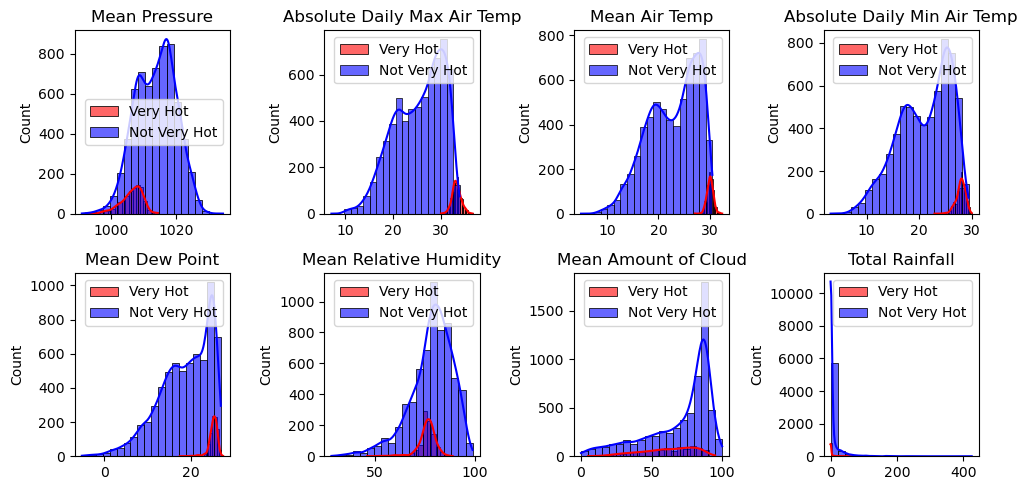

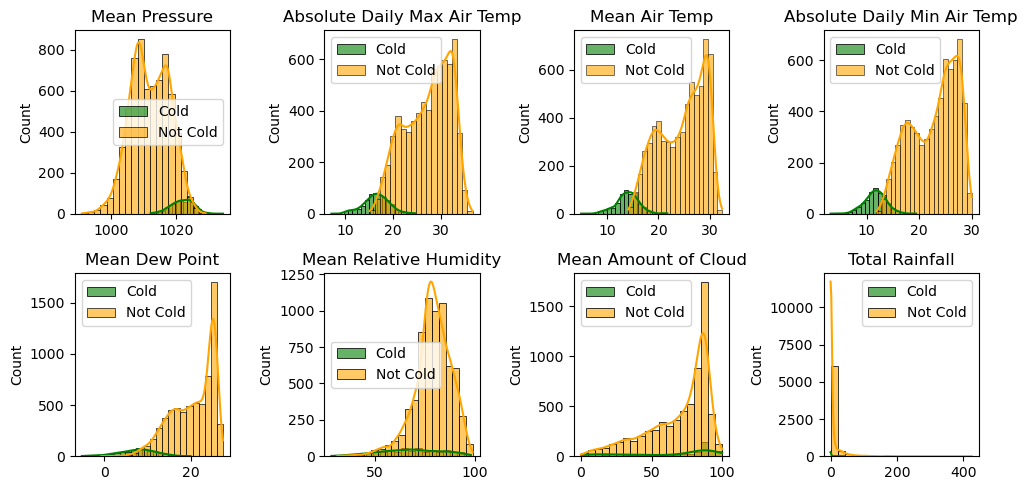

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

parameters = target_keys[1:]

plt.figure(figsize=(10, 5))
for i, param in enumerate(parameters):
    ax = plt.subplot(2, 4, i + 1)
    hot_values = []
    for i in df[df['Very Hot Weather Warning'] == True][param]:
        hot_values.append(float(i))
    sns.histplot(hot_values, label='Very Hot', color='red', kde=True, alpha=0.6, bins=20, ax=ax)
    
    not_hot_values = []
    for i in df[df['Very Hot Weather Warning'] == False][param]:
        not_hot_values.append(float(i))
    sns.histplot(not_hot_values, label='Not Very Hot', color='blue', kde=True, alpha=0.6, bins=20, ax=ax)
    plt.title(param)
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, param in enumerate(parameters):
    ax = plt.subplot(2, 4, i + 1)
    cold_values = []
    for i in df[df['Cold Weather Warning'] == True][param]:
        cold_values.append(float(i))
    sns.histplot(cold_values, label='Cold', color='green', kde=True, alpha=0.6, bins=20, ax=ax)
    
    not_cold_values = []
    for i in df[df['Cold Weather Warning'] == False][param]:
        not_cold_values.append(float(i))
    sns.histplot(not_cold_values, label='Not Cold', color='orange', kde=True, alpha=0.6, bins=20, ax=ax)
    plt.title(param)
    plt.legend()
plt.tight_layout()
plt.show()